In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt
import copy
import feather
import re

import matplotlib.pyplot as plt
import statsmodels.stats.stattools

%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
def plot_posterior_predictive(ppc, 
                              observations,
                              fun1 = lambda x: np.mean(x, axis = 1), 
                              fun2 = lambda x: np.mean(x),
                              xlab = "mean(x)",
                             title = "Posterior predictive of mean"):
    _, ax = plt.subplots(figsize=(12, 6))
    ax.hist(fun1(ppc['obs']), bins=20, alpha=0.5)
    ax.axvline(fun2(observations))
    ax.set(title=title, xlabel=xlab, ylabel='Frequency');

# PBMC 68k

In [4]:
def get_logfcs_comparison(df, type1, type2):
    type2 = re.sub("[ \+\\/]", ".", type2)
    return(np.array(df[df.cluster == type1]["logFC." + type2]))

In [5]:
sce_markers = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/pbmc68k_markers.feather')
sce_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/pbmc_68k_normal_logfcs.feather')

## Naive CD8+ vs. Naive CD4+

In [6]:
class1 = "Naive CD8+"
class2 = "Naive CD4+"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

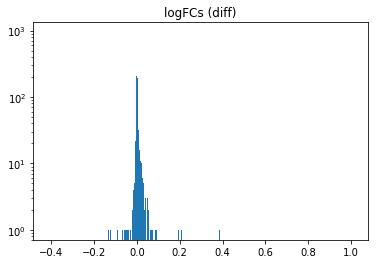

In [7]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

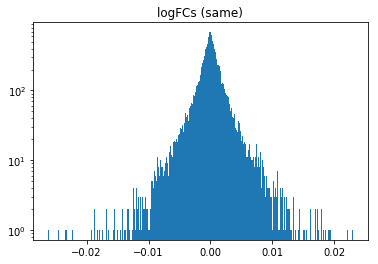

In [8]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

In [87]:
def zvalue(value, sd=1, mu=0):
    """
    Calculate the z-value for a normal distribution. By default standard normal.
    """
    return (value - mu) / tt.sqrt(2. * sd ** 2.)

def cdf(mu, sd, value):
    z = zvalue(value, mu=mu, sd=sd)
    return tt.erfc(-z / tt.sqrt(2.))/2.

def run_model(observations, nulls, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        # Probability of being a DE gene
        de_prob = pm.Uniform('de_prob', lower = 0., upper = 1.)

        # Probability of being downregulated
        down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for non-DE genes (learned from bootstrap resampling)
        mu_null = pm.Gamma('mu_null', alpha = 1., beta = 1.)
        sd_null = pm.Gamma('sd_null', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for DE genes
        mu_pos = pm.Lognormal('mu_pos', mu = 0., sd = 1.)
        mu_neg = pm.Lognormal('mu_neg', mu = 0., sd = 1.)

        sd = pm.Gamma('sd', alpha = 1., beta = 1.)

        # Sample from Gaussian for null
        pm.Normal('null',
                 mu = mu_null,
                 sd = sd_null,
                 observed = nulls)

        null_component = pm.Normal.dist(mu = mu_null,
                                      sd = sd_null)
        

        pos_component = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos, sd=sd)
        neg_component = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg, sd=sd)
        pos_component_abs = pm.Bound(pm.Normal, lower=0.).dist(mu=-1*mu_pos, sd=sd)
        neg_component_abs = pm.Bound(pm.Normal, upper=0.).dist(mu=mu_neg, sd=sd)
        
        #pos_component = pm.Deterministic('pos_component', tt.abs_(pm.Normal('pos_x', mu = mu_pos, sd = sd)))
        #neg_component = pm.Deterministic('neg_component', tt.abs_(pm.Normal('neg_x', mu = mu_neg, sd = sd)))
        
        cdf_pos = cdf(mu = mu_pos, sd = sd, value = 0.)
        cdf_neg = cdf(mu = -1*mu_neg, sd = sd, value = 0.)

#         pm.Mixture('obs',
#                   w = tt.as_tensor([(1.-de_prob), de_prob * (1.-down_prob), de_prob * down_prob]),
#                   comp_dists = [null_component, pos_component, neg_component],
#                   observed = observations)

        pm.Mixture('obs',
                  w = tt.as_tensor([(1.-de_prob), de_prob * (1.-down_prob) * (1.-cdf_pos), de_prob * down_prob * cdf_neg,
                                   de_prob * (1.-down_prob) * cdf_pos, de_prob * down_prob * (1.-cdf_neg)]),
                  comp_dists = [null_component, pos_component, neg_component, pos_component_abs,
                               neg_component_abs],
                  observed = observations)

        pm.Deterministic('log_prob', model.logpt)

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
        ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return({'trace': trace, 'ppc': ppc})


In [245]:
def run_model_outlier(observations, nulls, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        # Probability of being a DE gene
        de_prob = pm.Uniform('de_prob', lower = 0., upper = 1.)

        # Probability of being downregulated
        down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for non-DE genes (learned from bootstrap resampling)
        mu_null = pm.Gamma('mu_null', alpha = 1., beta = 1.)
        sd_null = pm.Gamma('sd_null', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for DE genes
        mu_pos = pm.Lognormal('mu_pos', mu = 0., sd = 1.)
        mu_neg = pm.Lognormal('mu_neg', mu = 0., sd = 1.)
        
#         mu_pos_outlier = pm.Lognormal('mu_pos_outlier', mu = 2., sd = 1.)
#         mu_neg_outlier = pm.Lognormal('mu_neg_outlier', mu = 2., sd = 1.)

        alpha_pos_outlier = pm.Lognormal('alpha_pos_outlier', mu = 0., sd = 1.)
        alpha_neg_outlier = pm.Lognormal('alpha_neg_outlier', mu = 0., sd = 1.)

        sd = pm.Gamma('sd', alpha = 1., beta = 1.)
        
        sd_outlier = pm.Gamma('sd_outlier', alpha = 20., beta = 1.)

        # Sample from Gaussian for null
        pm.Normal('null',
                 mu = mu_null,
                 sd = sd_null,
                 observed = nulls)

        null_component = pm.Normal.dist(mu = mu_null,
                                      sd = sd_null)

        

        pos_component = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos, sd=sd)
        neg_component = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg, sd=sd)
        pos_component_abs = pm.Bound(pm.Normal, lower=0.).dist(mu=-1*mu_pos, sd=sd)
        neg_component_abs = pm.Bound(pm.Normal, upper=0.).dist(mu=mu_neg, sd=sd)
        
#         pos_component_outlier = pm.Bound(pm.Normal, lower = 0.).dist(mu = mu_pos_outlier, sd = sd_outlier)
#         neg_component_outlier = pm.Bound(pm.Normal, upper = 0.).dist(mu = -1*mu_neg_outlier, sd = sd_outlier)

        pos_component_outlier = pm.Gamma.dist(alpha=alpha_pos_outlier * 10., beta = 10.)
        # Transform a Gamma distribution
        neg_component_outlier = pm.DensityDist.dist(lambda x: pm.Gamma.dist(alpha_neg_outlier * 10., 10.).logp(-x))

        # Come up with better priors for this
        mult_constant = 1000.
        prior_prob = 0.01
        outlier_prob = pm.Beta('outlier_prob', alpha = prior_prob * mult_constant, beta = (1.-prior_prob) * mult_constant)
        
        #pos_component = pm.Deterministic('pos_component', tt.abs_(pm.Normal('pos_x', mu = mu_pos, sd = sd)))
        #neg_component = pm.Deterministic('neg_component', tt.abs_(pm.Normal('neg_x', mu = mu_neg, sd = sd)))
        
        cdf_pos = cdf(mu = mu_pos, sd = sd, value = 0.)
        cdf_neg = cdf(mu = -1*mu_neg, sd = sd, value = 0.)

#         pm.Mixture('obs',
#                   w = tt.as_tensor([(1.-de_prob), de_prob * (1.-down_prob), de_prob * down_prob]),
#                   comp_dists = [null_component, pos_component, neg_component],
#                   observed = observations)

        pm.Mixture('obs',
                  w = tt.as_tensor([(1.-de_prob), de_prob * (1.-down_prob) * (1.-cdf_pos) * (1.-outlier_prob), de_prob * down_prob * cdf_neg * (1.-outlier_prob),
                                   de_prob * (1.-down_prob) * cdf_pos * (1.-outlier_prob), de_prob * down_prob * (1.-cdf_neg) * (1.-outlier_prob),
                                   outlier_prob * de_prob * (1.-down_prob), outlier_prob * de_prob * down_prob]),
                  comp_dists = [null_component, pos_component, neg_component, pos_component_abs,
                               neg_component_abs, pos_component_outlier, neg_component_outlier],
                  observed = observations)

        pm.Deterministic('log_prob', model.logpt)

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
        ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return({'trace': trace, 'ppc': ppc})

In [101]:
x = cdf(-0.2, 1, 0)
x.eval()

array(0.55623146)

In [88]:
pbmc_nonoutlier_res = run_model(logfcs_diff, logfcs_same, iter_count=500, tune_iters = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 500/500 [00:11<00:00, 44.48it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8518ec780>,
      dtype=object)

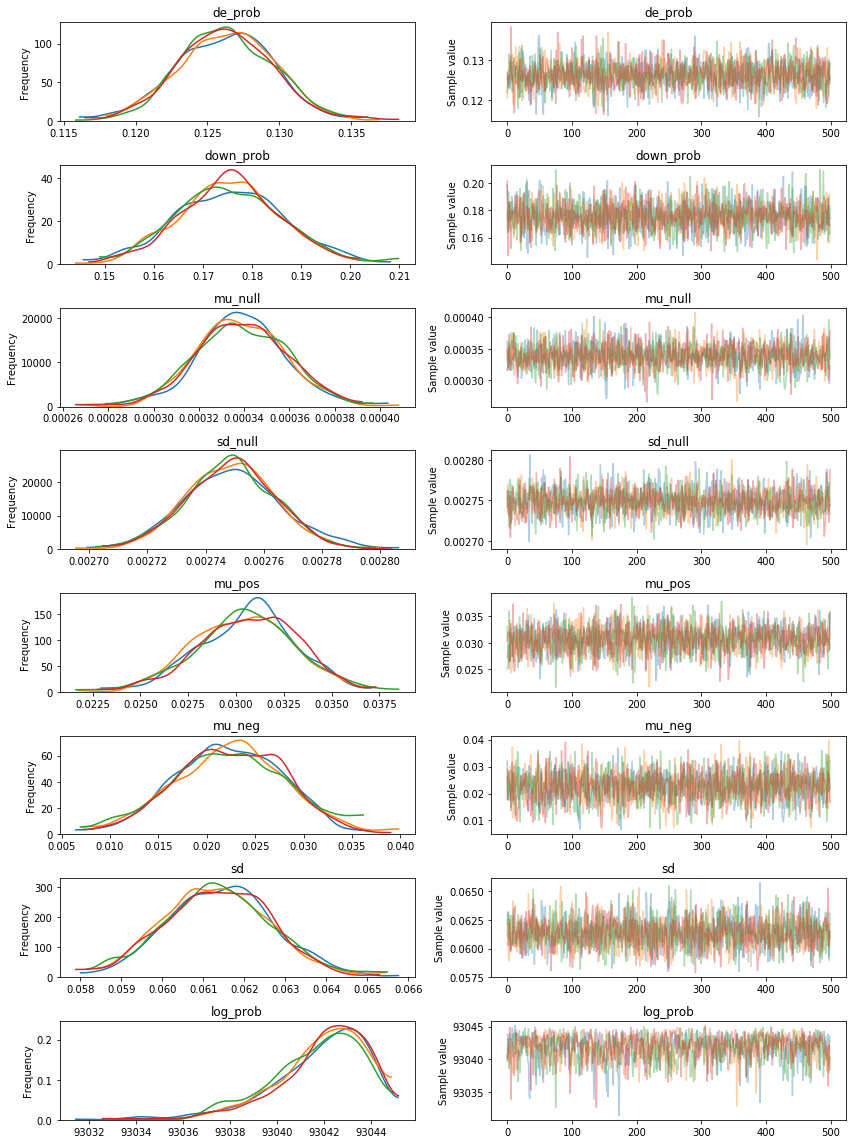

In [122]:
pm.traceplot(pbmc_nonoutlier_res['trace'])

In [28]:
pbmc_outlier_res = run_model_outlier(logfcs_diff, logfcs_same, iter_count=500, tune_iters = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [outlier_prob, sd_outlier, sd, mu_neg_outlier, mu_pos_outlier, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 500/500 [01:18<00:00,  6.38it/s]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [outlier_prob, sd_outlier, sd, mu_neg_outlier, mu_pos_outlier, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 500/500 [01:19<00:00,  6.28it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc864943588>,
      dtype=object)

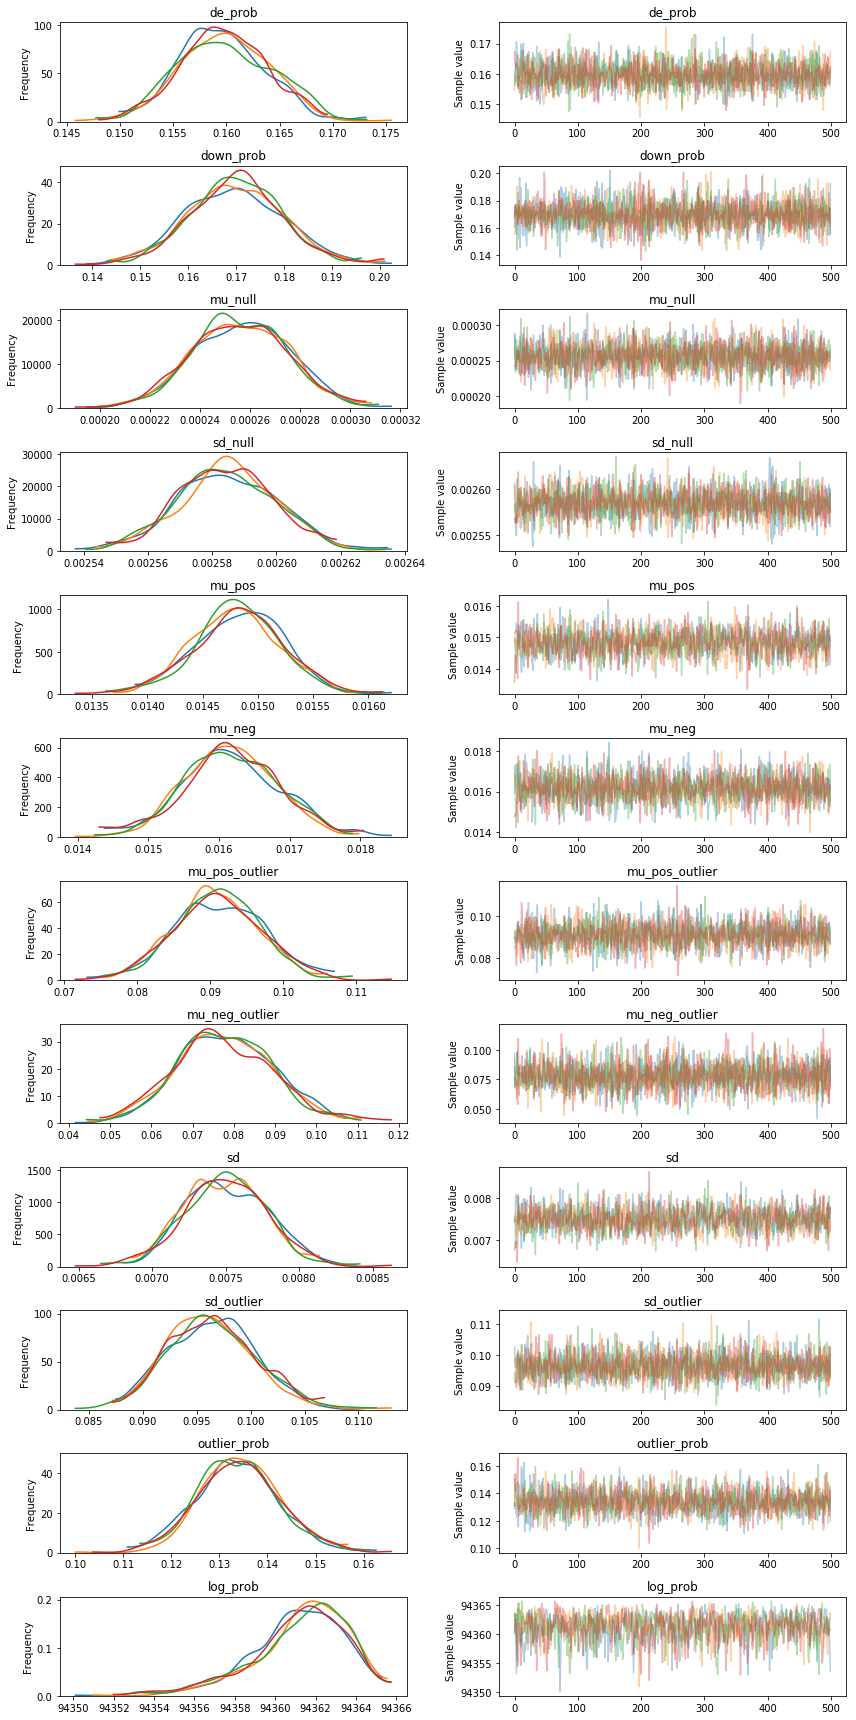

In [104]:
pbmc_outlier_res2 = run_model_outlier(logfcs_diff, logfcs_same, iter_count=500, tune_iters = 1000)

pm.traceplot(pbmc_outlier_res2['trace'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [outlier_prob, sd_outlier, sd, alpha_neg_outlier, alpha_pos_outlier, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 500/500 [00:25<00:00, 19.85it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8a992e278>,
      dtype=object)

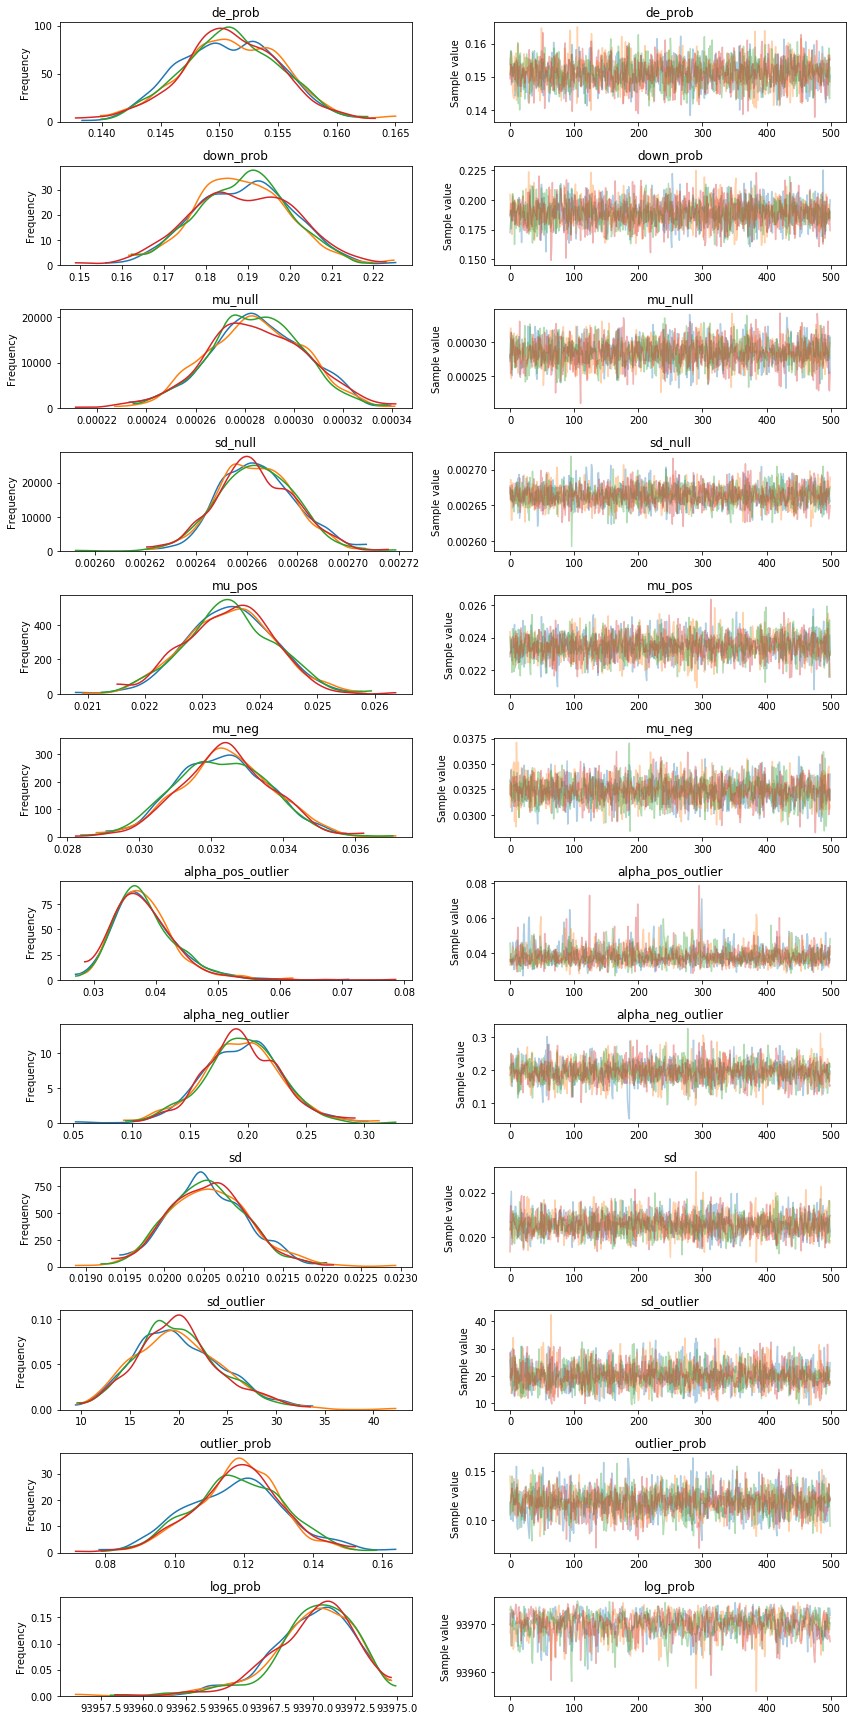

In [124]:
pbmc_outlier_res3 = run_model_outlier(logfcs_diff, logfcs_same, iter_count=500, tune_iters = 1000)

pm.traceplot(pbmc_outlier_res3['trace'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc89b6619b0>,
      dtype=object)

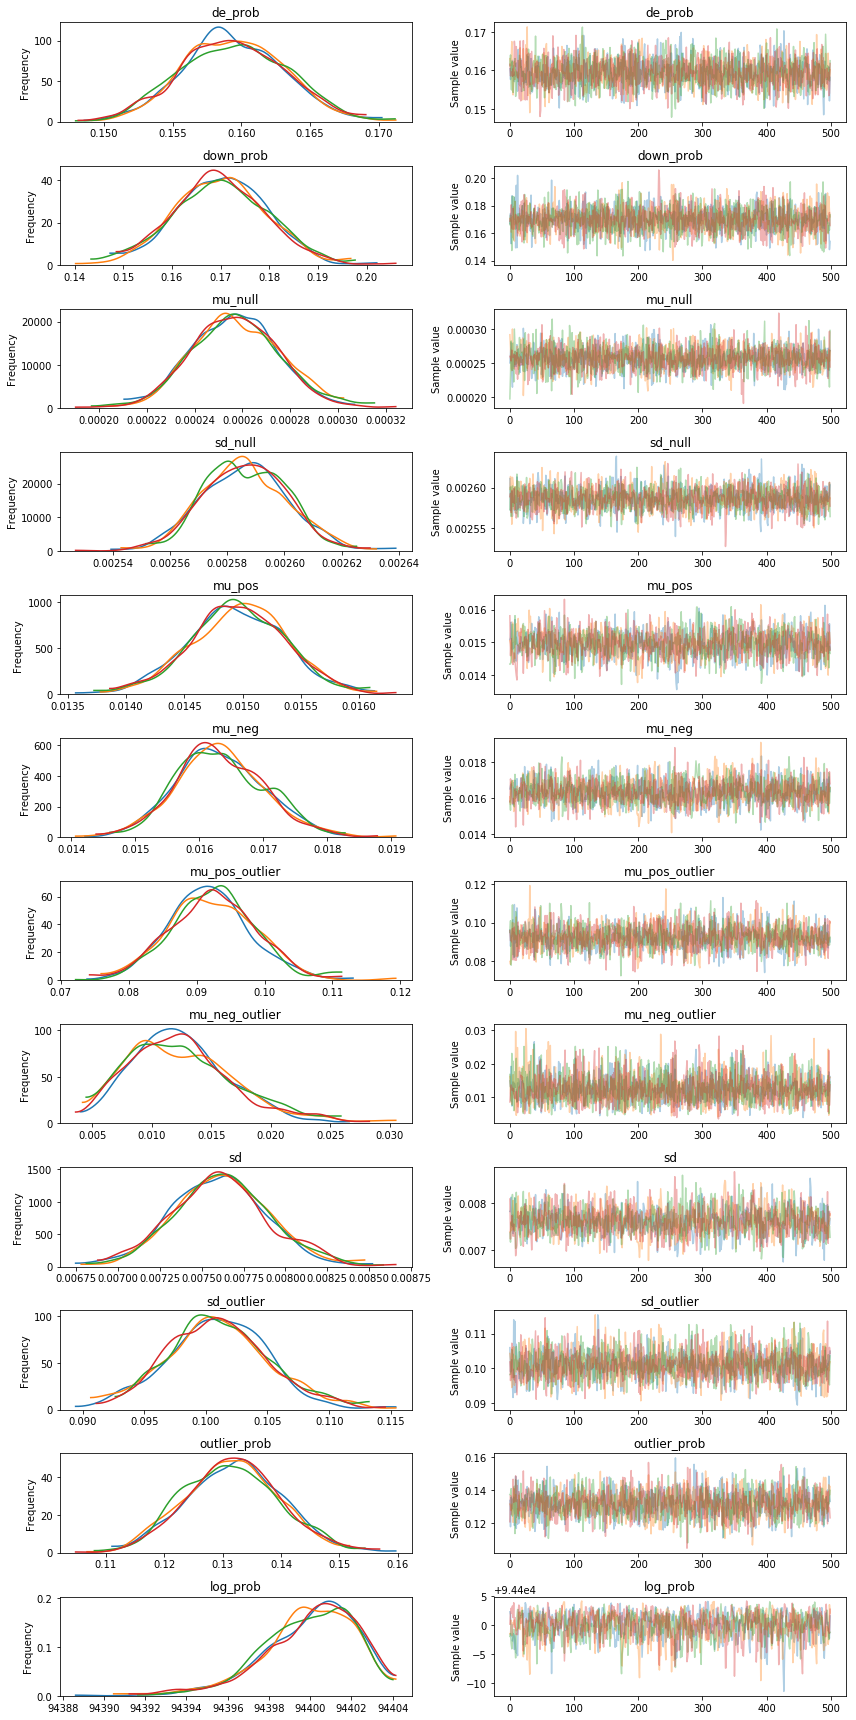

In [29]:
pm.traceplot(pbmc_outlier_res['trace'])

In [30]:
pm.summary(pbmc_outlier_res['trace'])

mean        sd      mc_error       hpd_2.5  \
de_prob             0.159390  0.003706  6.277925e-05      0.152275   
down_prob           0.169979  0.009389  1.674617e-04      0.151426   
mu_null             0.000257  0.000018  2.881354e-07      0.000224   
sd_null             0.002586  0.000015  2.718974e-07      0.002559   
mu_pos              0.014955  0.000406  1.033032e-05      0.014099   
mu_neg              0.016318  0.000681  1.445205e-05      0.015034   
mu_pos_outlier      0.092219  0.006254  1.165353e-04      0.080204   
mu_neg_outlier      0.012536  0.004416  8.236147e-05      0.004651   
sd                  0.007613  0.000286  7.758595e-06      0.007060   
sd_outlier          0.101058  0.004129  8.243357e-05      0.093028   
outlier_prob        0.131652  0.008019  1.948474e-04      0.116866   
log_prob        94399.935715  2.228057  6.585080e-02  94395.498553   

                    hpd_97.5        n_eff      Rhat  
de_prob             0.166492  2741.065946  0.999251  
down_prob           0.188012  3817.293837  0.999194  
mu_null             0.000294  3367.068132  0.999460  
sd_null             0.002615  2616.189262  0.999142  
mu_pos              0.015711  1304.516488  0.999732  
mu_neg              0.017687  1791.626419  0.999173  
mu_pos_outlier      0.104152  2227.165884  1.000201  
mu_neg_outlier      0.020942  3169.864210  0.999230  
sd                  0.008198  1339.521551  1.000578  
sd_outlier          0.109412  2272.306081  0.999883  
outlier_prob        0.147655  1830.857947  1.000590  
log_prob        94403.642655   908.728019  0.999993

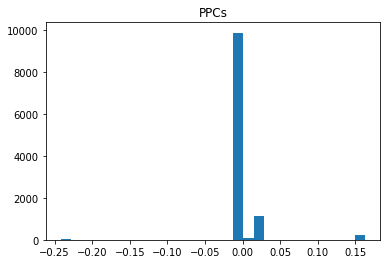

In [69]:
plt.hist(pbmc_outlier_res['ppc']['obs'][1], bins=30) 
plt.title("PPCs")
plt.show()

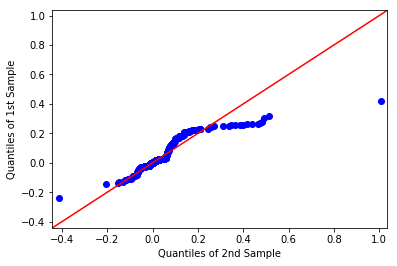

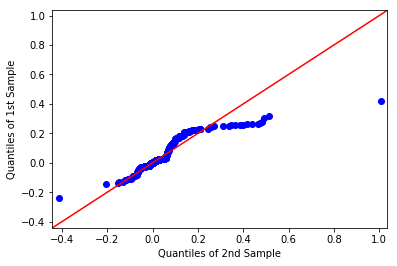

In [91]:
import statsmodels.graphics.gofplots

pred_samples = np.random.choice(pbmc_outlier_res['ppc']['obs'].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

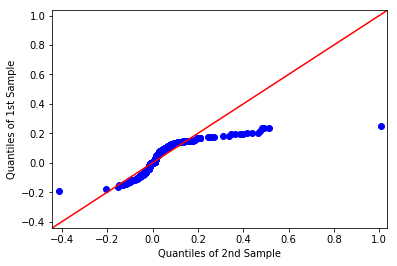

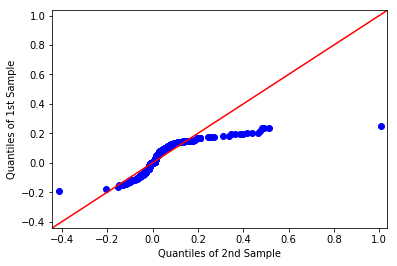

In [92]:
pred_samples = np.random.choice(pbmc_nonoutlier_res['ppc']['obs'].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

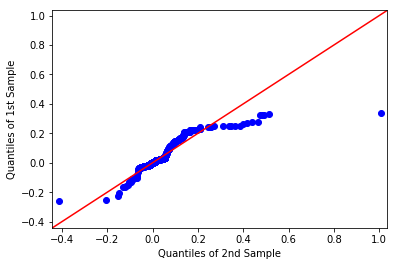

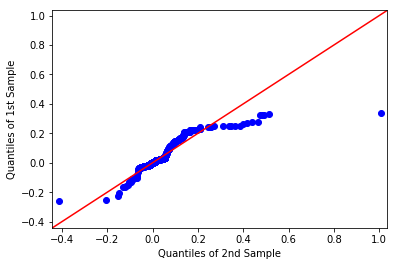

In [107]:
pred_samples = np.random.choice(pbmc_outlier_res2['ppc']['obs'].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

In [117]:
np.max(pbmc_outlier_res3['ppc']['obs'])

531.7680454514164

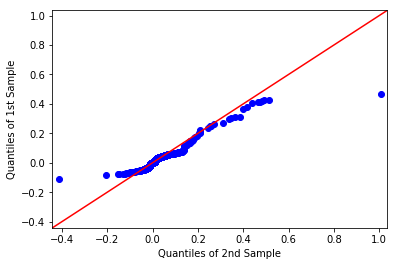

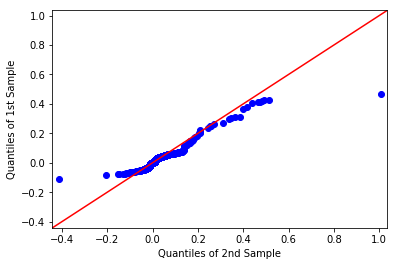

In [129]:
pred_samples = np.random.choice(pbmc_outlier_res3['ppc']['obs'].flatten(), size = logfcs_diff.shape[0])
statsmodels.graphics.gofplots.qqplot_2samples(pred_samples, logfcs_diff, line = '45')

In [59]:
pd.hist(pbmc_outlier_res['ppc']['obs'][1])

AttributeError: module 'pandas' has no attribute 'hist'

In [40]:
logfcs_diff.shape

(11386,)

In [176]:
with pm.Model() as model:
    x = pm.Normal('hi', mu=2., sd=1.)
    x2 = pm.Normal('hi3')
    y = pm.Deterministic('hi2', x + 2)
    z = pm.Normal.dist(mu=2., sd=1.)
    z3 = pm.Mixture.dist(w = [0.5, 0.5], comp_dists=[z, z])

print(type(x2))
print(type(x))
print(type(y))
print(type(z))
print(type(z3))

#pm.Normal.dist(mu = 2., sd = 1.).logp(2).eval()
#z3.logp(3).eval()

print(pm.Gamma.dist(alpha=2 * 10., beta = 10.).logp(2).eval())

    
pm.


<class 'pymc3.model.FreeRV'>
<class 'pymc3.model.FreeRV'>
<class 'theano.tensor.var.TensorVariable'>
<class 'pymc3.distributions.continuous.Normal'>
<class 'pymc3.distributions.mixture.Mixture'>
-0.118385315


AttributeError: 'function' object has no attribute 'name'

<class 'pymc3.distributions.distribution.DensityDist'>
-inf
-2.9189384
<class 'pymc3.distributions.continuous.Gamma'>
<class 'pymc3.model.FreeRV'>


array(-2.9189384, dtype=float32)

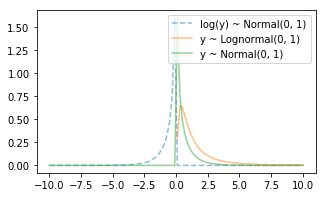

In [244]:
import pymc3.distributions.transforms as tr

class Neg(tr.ElemwiseTransform):
    name = "neg"

    def backward(self, x):
        return -x

    def forward(self, x):
        return -x

    def jacobian_det(self, x):
        return tt.zeros(shape = x.shape)


with pm.Model() as model:
    x1 = pm.Gamma('x1', 0.5, 1., transform=Neg())
    x2 = pm.Lognormal('x2', 0., 1.)
    x3 = pm.Gamma('x3', 0.5, 1.)
    print(type(pm.DensityDist.dist(lambda x: pm.Normal.dist(1, 1).logp(-x))))

lognorm1 = model.named_vars['x1_neg__']
lognorm2 = model.named_vars['x2']
lognorm3 = model.named_vars['x3']

_, ax = plt.subplots(1, 1, figsize=(5, 3))
x = np.linspace(-10., 10., 100)
ax.plot(
    x,
    np.exp(lognorm1.distribution.logp(x).eval()),
    '--',
    alpha=.5,
    label='log(y) ~ Normal(0, 1)')
ax.plot(
    x,
    np.exp(lognorm2.distribution.logp(x).eval()),
    alpha=.5,
    label='y ~ Lognormal(0, 1)')
ax.plot(
    x,
    np.exp(lognorm3.distribution.logp(x).eval()),
    alpha=.5,
    label='y ~ Normal(0, 1)')
plt.legend();

print(pm.Gamma.dist(0.5, 1., transform = Neg()).logp(-2).eval())
print(pm.Gamma.dist(0.5, 1.).logp(2).eval())
print(type(pm.Gamma.dist(0.5, 1., transform = Neg())))
print(type(lognorm1))

pm.DensityDist.dist(lambda x: pm.Gamma.dist(0.5, 1).logp(-x)).logp(-2).eval()

In [58]:
bf_trace_old = bf_trace

In [65]:
bf_trace = bf_comparison(logfcs_diff, logfcs_same, iter_count=1000, tune_iters = 100)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [true_model]
>NUTS: [de_prob, down_prob, mu_null, sd_null, mu_pos, mu_neg, sd, de_prob2, down_prob2, mu_null2, sd_null2, mu_pos2, mu_neg2, sd2]
Sampling 4 chains: 100%|██████████| 4400/4400 [1:47:10<00:00,  5.84s/draws]
The acceptance probability does not match the target. It is 0.8939545243679989, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8956389576316923, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the m

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5dd0549d68>,
      dtype=object)

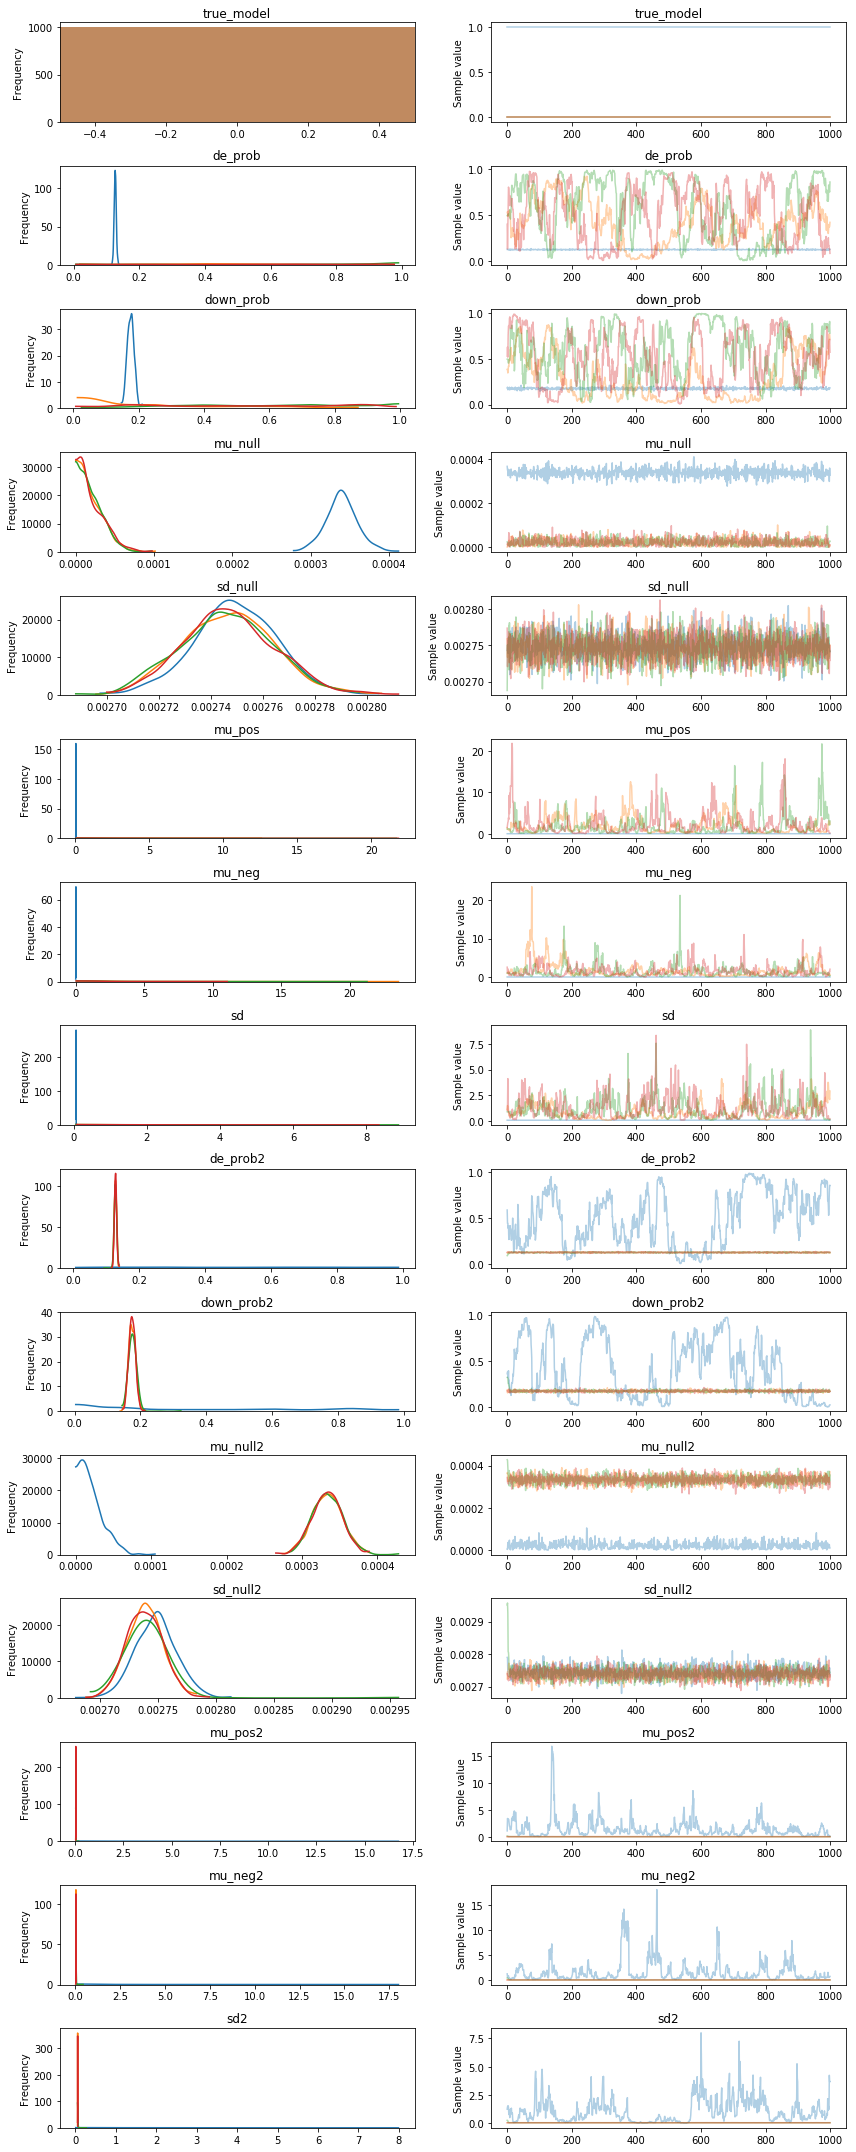

In [66]:
pm.traceplot(bf_trace)

In [67]:
pm.summary(bf_trace)

mean        sd      mc_error       hpd_2.5  hpd_97.5  \
true_model  0.250000  0.433013  4.330127e-02  0.000000e+00  1.000000   
de_prob     0.410636  0.299176  2.641112e-02  2.891625e-02  0.952239   
down_prob   0.386892  0.280059  2.473665e-02  1.905740e-02  0.919873   
mu_null     0.000100  0.000139  1.382212e-05  8.169360e-09  0.000355   
sd_null     0.002747  0.000017  3.157198e-07  2.712369e-03  0.002780   
mu_pos      1.489412  2.213905  1.491143e-01  2.040594e-02  5.462767   
mu_neg      1.165439  1.576999  1.051921e-01  6.397925e-03  3.965449   
sd          0.816761  0.922909  6.385380e-02  5.264287e-02  2.623377   
de_prob2    0.220410  0.213659  1.995597e-02  4.435753e-02  0.804297   
down_prob2  0.233980  0.185679  1.652100e-02  3.086110e-03  0.757634   
mu_null2    0.000255  0.000137  1.353247e-05  1.241866e-06  0.000365   
sd_null2    0.002741  0.000017  5.219351e-07  2.707513e-03  0.002772   
mu_pos2     0.394664  1.064172  7.898661e-02  2.939234e-02  2.099672   
mu_neg2     0.420170  1.254098  8.931258e-02  2.165596e-02  2.182883   
sd2         0.314275  0.686684  5.726507e-02  8.396596e-03  1.791031   

                  n_eff      Rhat  
true_model          NaN       inf  
de_prob        6.790526  1.292363  
down_prob      8.053531  1.296149  
mu_null        2.024784  9.439677  
sd_null     3801.028694  1.003605  
mu_pos        22.476717  1.110034  
mu_neg        15.187404  1.140098  
sd             9.546628  1.197389  
de_prob2       3.651691  1.647950  
down_prob2    10.686100  1.255520  
mu_null2       2.032019  8.295263  
sd_null2      82.810403  1.033553  
mu_pos2        6.727831  1.300802  
mu_neg2        9.666173  1.239029  
sd2            5.250149  1.404471

In [48]:
p = bf_trace['true_model'].mean()  
BF = ((1-p)/p) * (0.5/0.5)  

BF

inf

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5dd564a1d0>,
      dtype=object)

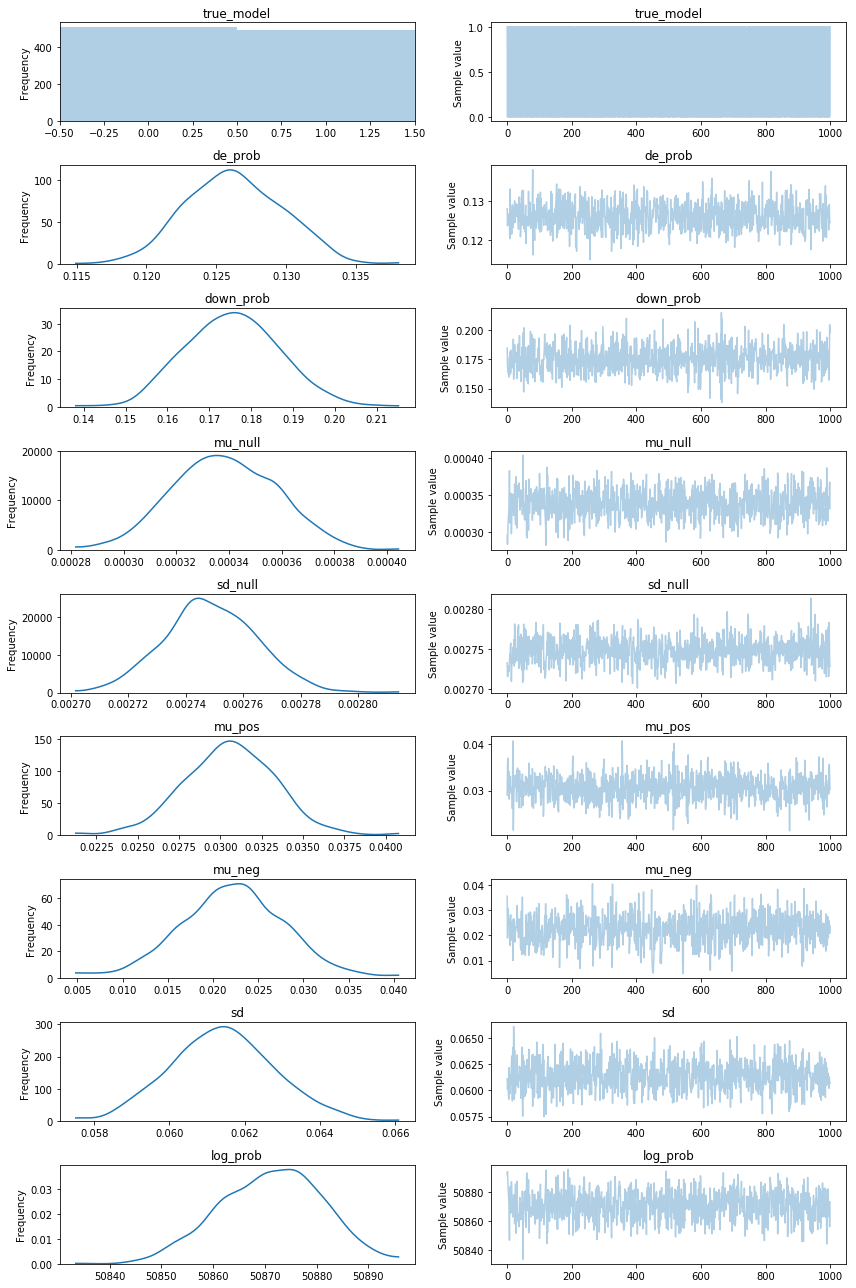

In [39]:
pm.plots.traceplot(bf_trace)

In [41]:
pm.summary(bf_trace)

mean        sd      mc_error       hpd_2.5      hpd_97.5
true_model      0.491000  0.499919  7.495999e-03      0.000000      1.000000
de_prob         0.126224  0.003440  1.176347e-04      0.120317      0.133117
down_prob       0.175440  0.011201  3.715793e-04      0.154830      0.196748
mu_null         0.000338  0.000019  6.299605e-07      0.000302      0.000375
sd_null         0.002748  0.000016  5.214764e-07      0.002719      0.002781
mu_pos          0.030527  0.002740  8.082222e-05      0.025780      0.036600
mu_neg          0.022111  0.005827  2.043215e-04      0.010591      0.033307
sd              0.061396  0.001354  4.286730e-05      0.058718      0.063954
log_prob    50871.050540  9.787164  3.220441e-01  50850.608146  50887.792833

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 1000/1000 [00:22<00:00, 45.29it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f970225f898>,
      dtype=object)

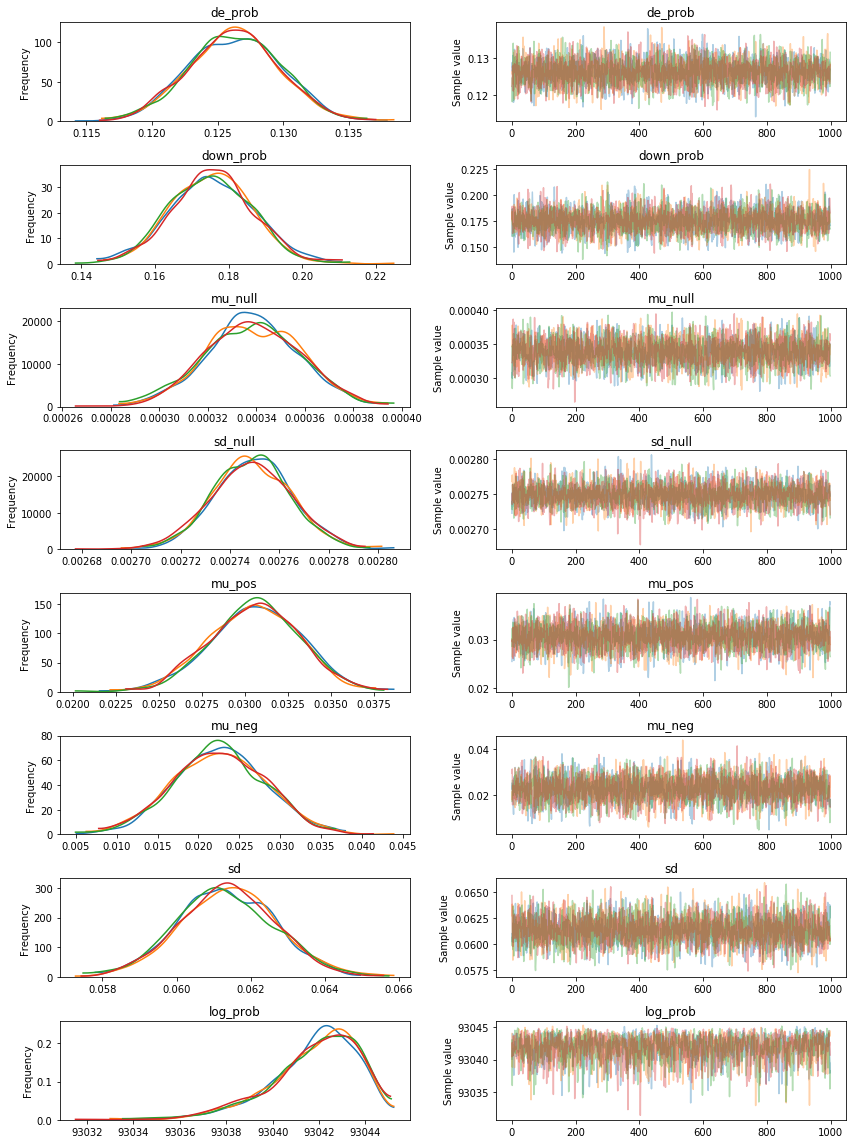

In [105]:
pbmc_res = run_model(logfcs_diff, logfcs_same, iter_count=1000, tune_iters = 1000)

pm.plots.traceplot(pbmc_res['trace'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 2000/2000 [00:21<00:00, 94.26it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96efedce80>,
      dtype=object)

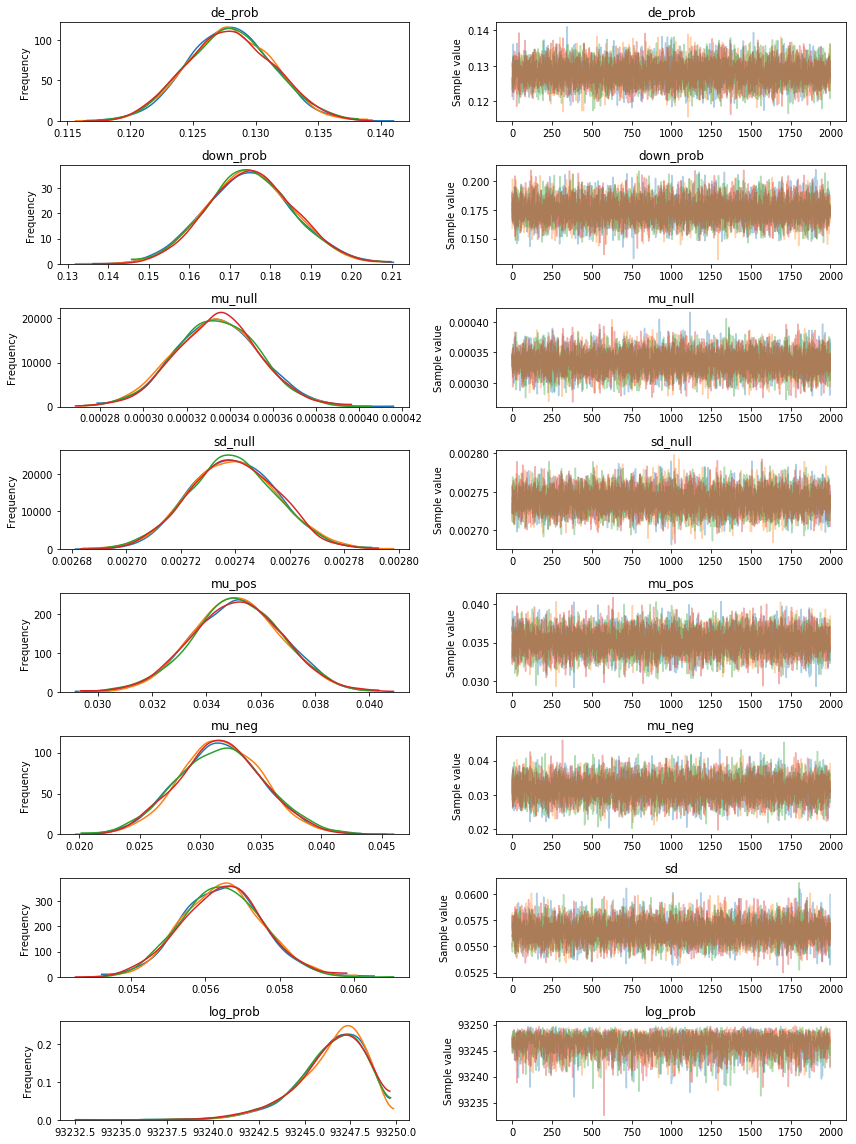

In [100]:
pbmc_res = run_model(logfcs_diff, logfcs_same, iter_count=2000, tune_iters = 2000)

pm.plots.traceplot(pbmc_res['trace'])

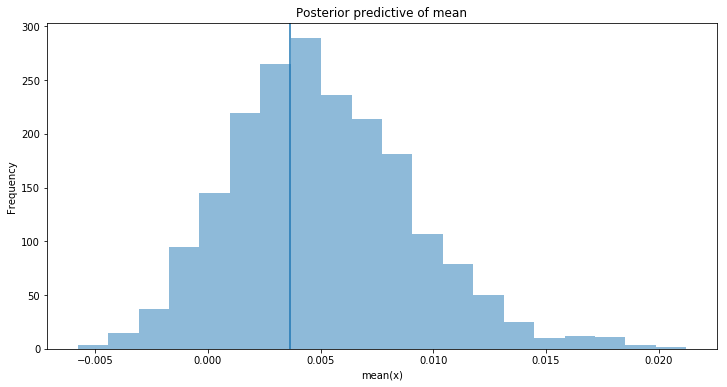

In [91]:
plot_posterior_predictive(pbmc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.mean(x, axis = 1), 
                          fun2 = lambda x: np.mean(x), 
                          xlab = "mean(x)",
                          title = "Posterior predictive of mean")

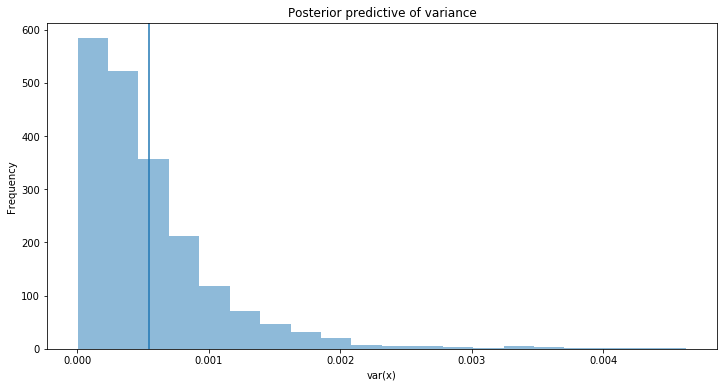

In [92]:
plot_posterior_predictive(pbmc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.var(x, axis = 1), 
                          fun2 = lambda x: np.var(x), 
                          xlab = "var(x)",
                          title = "Posterior predictive of variance")

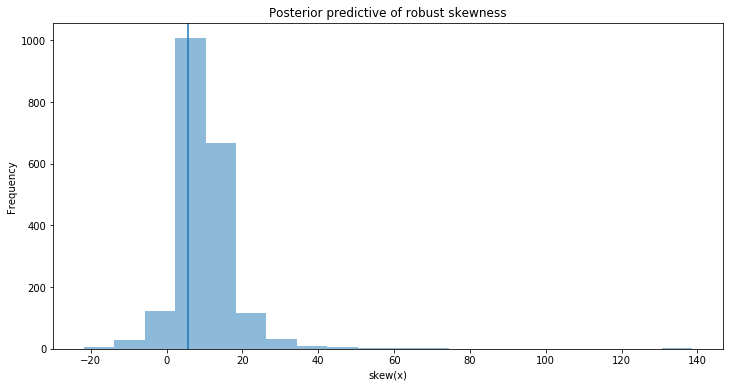

In [93]:
plot_posterior_predictive(pbmc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: statsmodels.stats.stattools.robust_skewness(x, axis = 1)[3], 
                          fun2 = lambda x: statsmodels.stats.stattools.robust_skewness(x)[3], 
                          xlab = "skew(x)",
                          title = "Posterior predictive of robust skewness")

These posterior predictive checks provide support that our model parameters approximately recapitulate the input data. 

In [112]:
sce_markers.head(5)

cluster  Top  FDR   logFC.B  logFC.B..dendritic..T  logFC.CD8.  \
0  Activated CD8+    1  0.0  3.308510               3.223352    1.503564   
1  Activated CD8+    1  0.0  3.431245               3.422709    0.947874   
2  Activated CD8+    1  0.0  3.650582               3.606749    2.619801   
3  Activated CD8+    1  0.0  1.410254               1.370745    0.349305   
4  Activated CD8+    1  0.0  1.351643               1.357580    1.267222   

   logFC.Megakaryocytes  logFC.Memory.and.Reg.T  \
0              3.205693                3.292188   
1              0.445943                3.202385   
2              3.553104                3.633361   
3              1.323605                0.276273   
4              1.291606                1.358415   

   logFC.Monocytes.and.dendritic  logFC.Naive.CD4.  logFC.Naive.CD8.  \
0                       3.172427          3.364977          3.299910   
1                       3.417239          3.447641          3.238764   
2                       3.577226          3.706064          3.682098   
3                       1.374793          0.458424          0.343195   
4                       1.348757          1.363011          1.354460   

   logFC.NK             Gene  logFC.Activated.CD8.  Symbol  
0 -0.552253  ENSG00000105374                   NaN    NKG7  
1  1.621012  ENSG00000161570                   NaN    CCL5  
2 -0.610140  ENSG00000115523                   NaN    GNLY  
3  1.418768  ENSG00000167286                   NaN    CD3D  
4 -0.079288  ENSG00000137441                   NaN  FGFBP2

## CD8+ vs. Naive CD4+

In [130]:
class1 = "B"
class2 = "CD8+"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

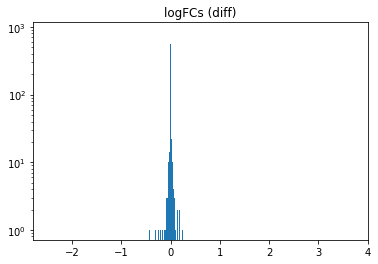

In [131]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

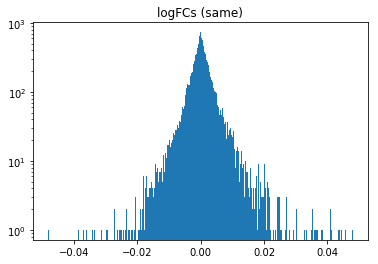

In [132]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
Sampling 4 chains: 100%|██████████| 8000/8000 [03:07<00:00, 42.77draws/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6751305271583041, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 1000/1000 [00:20<00:00, 48.42it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc88bd4e780>,
      dtype=object)

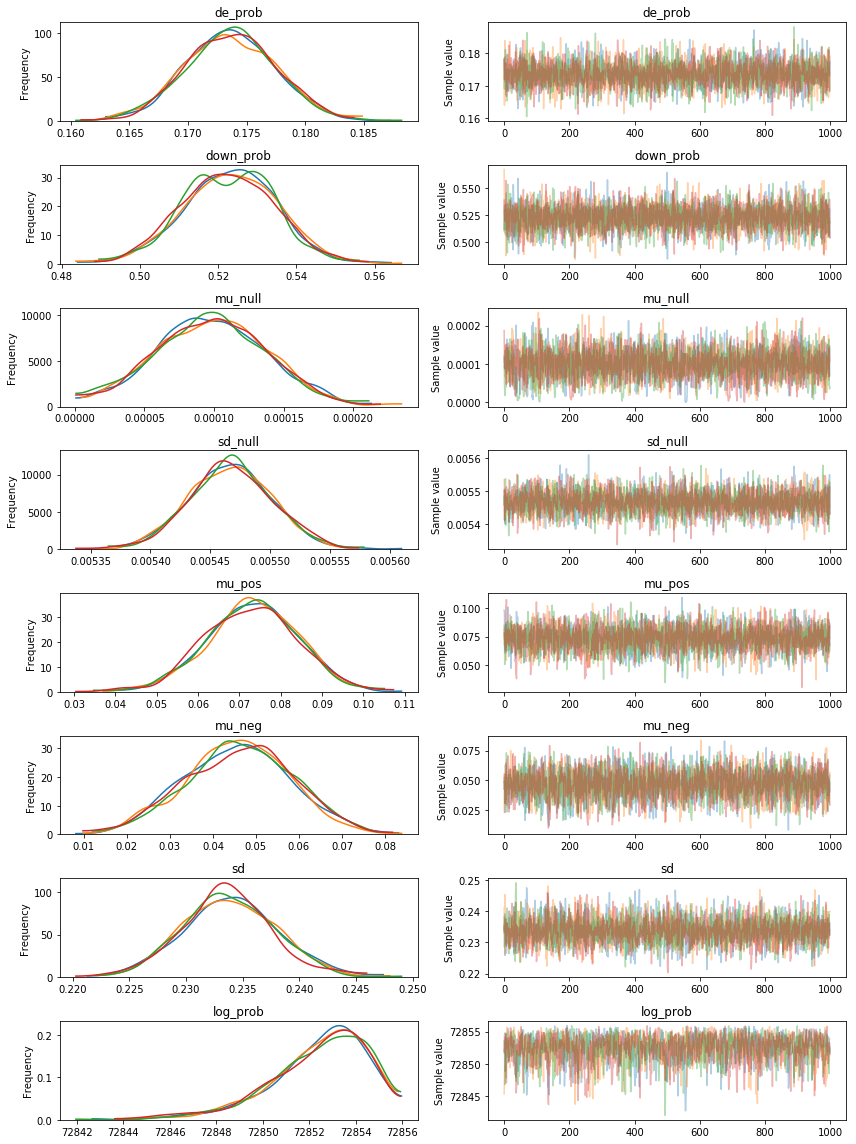

In [133]:
pbmc_res = run_model(logfcs_diff, logfcs_same, iter_count=1000, tune_iters = 1000)

pm.plots.traceplot(pbmc_res['trace'])

In [247]:
pm.__version__

'3.4.1'

In [246]:
pbmc_outlier_res4 = run_model_outlier(logfcs_diff, logfcs_same, iter_count=500, tune_iters = 1000)

pm.traceplot(pbmc_outlier_res4['trace'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [outlier_prob, sd_outlier, sd, alpha_neg_outlier, alpha_pos_outlier, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
  0%|          | 0/500 [00:00<?, ?it/s]

ValueError: Distribution was not passed any random method Define a custom random method and pass it as kwarg random

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
Sampling 4 chains: 100%|██████████| 8000/8000 [02:05<00:00, 20.51draws/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 1000/1000 [00:21<00:00, 45.92it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f972d1442b0>,
      dtype=object)

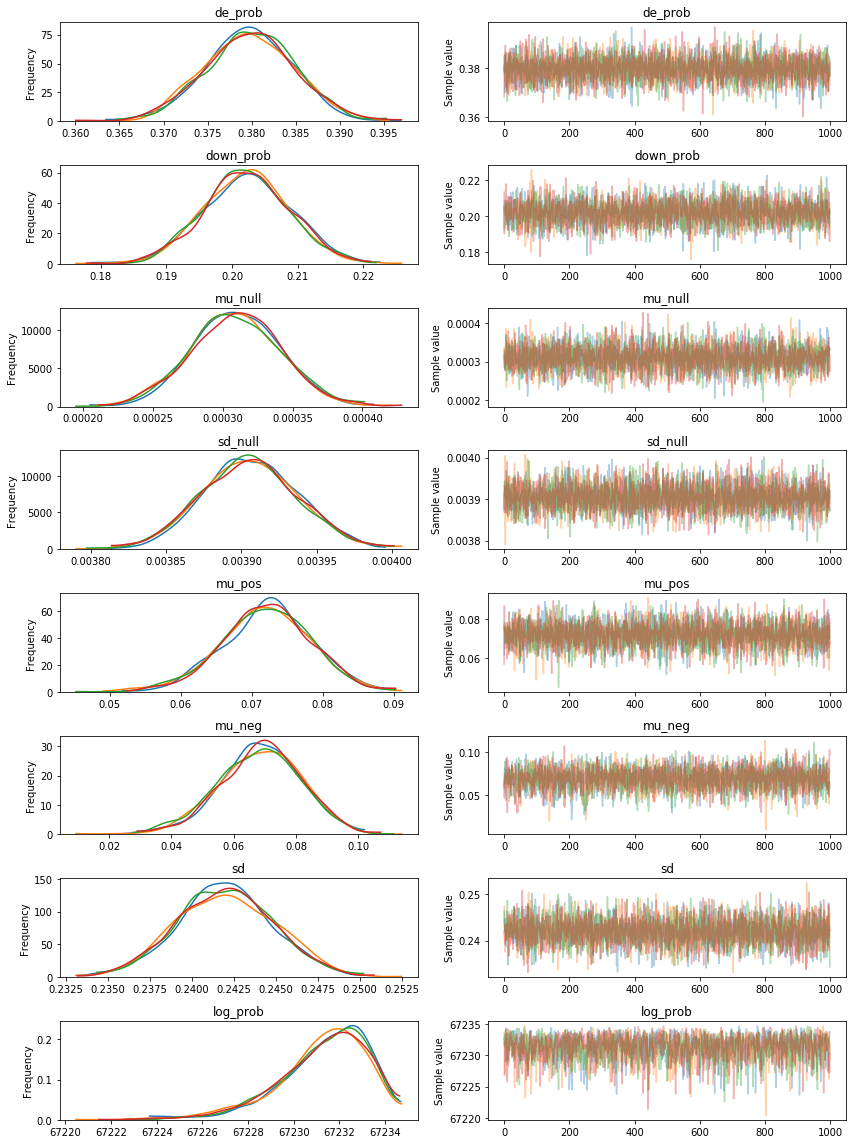

In [118]:
pbmc_res = run_model(logfcs_diff, logfcs_same, iter_count=1000, tune_iters = 1000)

pm.plots.traceplot(pbmc_res['trace'])

# HGSC high confidence

We'll perform the same analysis, but on the HGSC data that has been generated locally.

In [120]:
sce_markers = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/hgsc_markers.feather')
sce_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/hgsc_normal_logfcs.feather')

In [121]:
sce_markers.head(5)

cluster  Top            FDR  logFC.Cancer.cell  logFC.CD4.T.cells  \
0  B cells    1  6.198315e-314          -3.818161          -0.147442   
1  B cells    1  1.078661e-261          -2.433924           0.014814   
2  B cells    1  6.216684e-237           0.006792           0.014299   
3  B cells    1  2.571330e-209          -0.004717          -1.338659   
4  B cells    1   5.002838e-76          -0.505529           1.871738   

   logFC.Cytotoxic.T.cells  logFC.Endothelial.cells  \
0                -0.026770                 0.033721   
1                 0.015954                -0.907922   
2                -1.399068                -0.000536   
3                -1.185269                -0.012082   
4                 1.994309                 1.619378   

   logFC.Fibroblast.Myofibroblast  logFC.Monocyte.Macrophage  logFC.NK.cells  \
0                       -0.003174                   0.025682       -0.110829   
1                       -2.140297                  -2.931242        0.032732   
2                        0.000776                  -0.000304       -0.003335   
3                        0.005803                  -0.011113       -0.153698   
4                        3.544489                  -1.732128        2.582217   

              Gene  logFC.B.cells Symbol  
0  ENSG00000101443            NaN  WFDC2  
1  ENSG00000101439            NaN   CST3  
2  ENSG00000153563            NaN   CD8A  
3  ENSG00000198851            NaN   CD3E  
4  ENSG00000019582            NaN   CD74

## CD4+ vs. CD8+ T cells

In [122]:
class1 = "CD4 T cells"
class2 = "Cytotoxic T cells"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

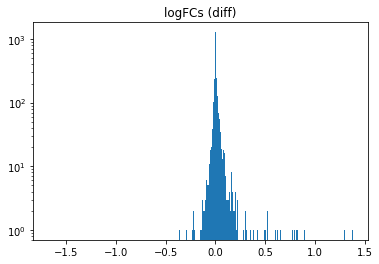

In [108]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

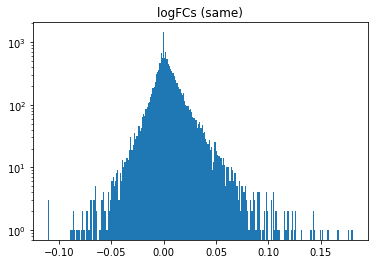

In [109]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 1000/1000 [00:29<00:00, 33.68it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9700ac27b8>,
      dtype=object)

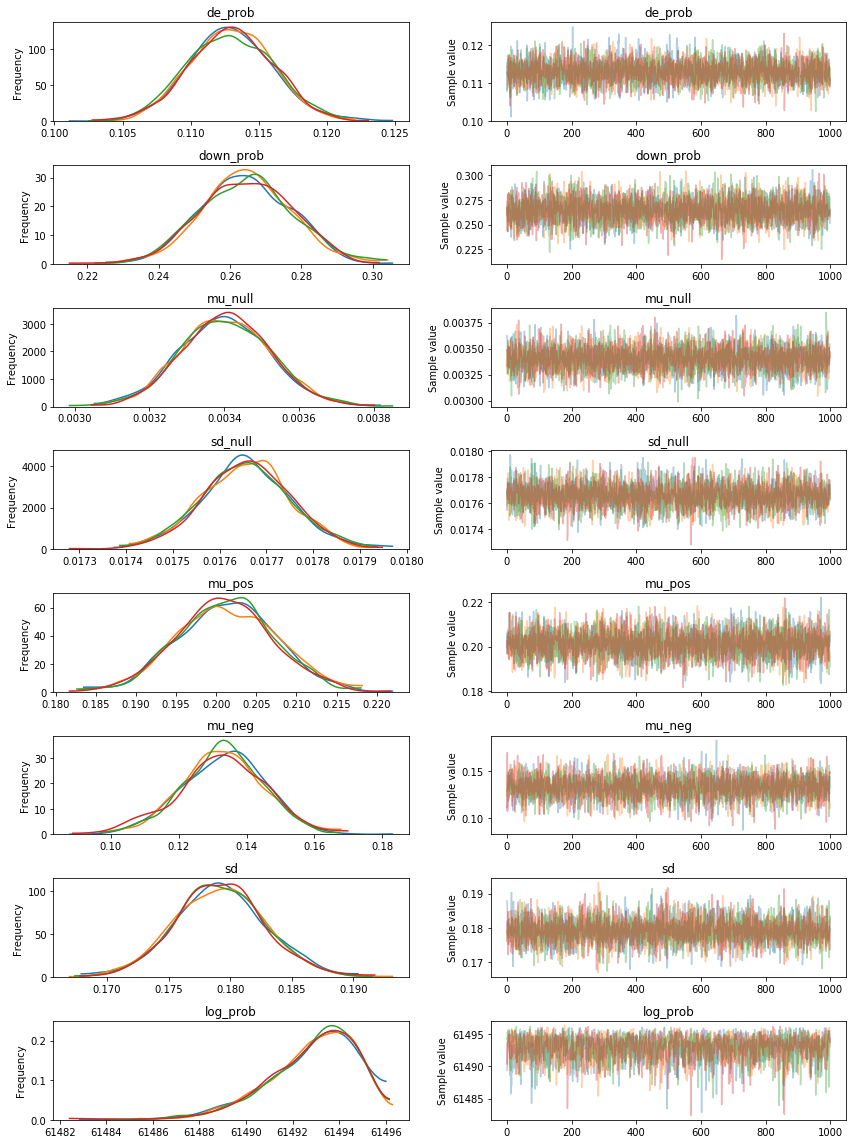

In [110]:
hgsc_res = run_model(logfcs_diff, logfcs_same, iter_count=1000, tune_iters = 1000)

pm.plots.traceplot(hgsc_res['trace'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 2000/2000 [00:20<00:00, 96.94it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f973a1d2a58>,
      dtype=object)

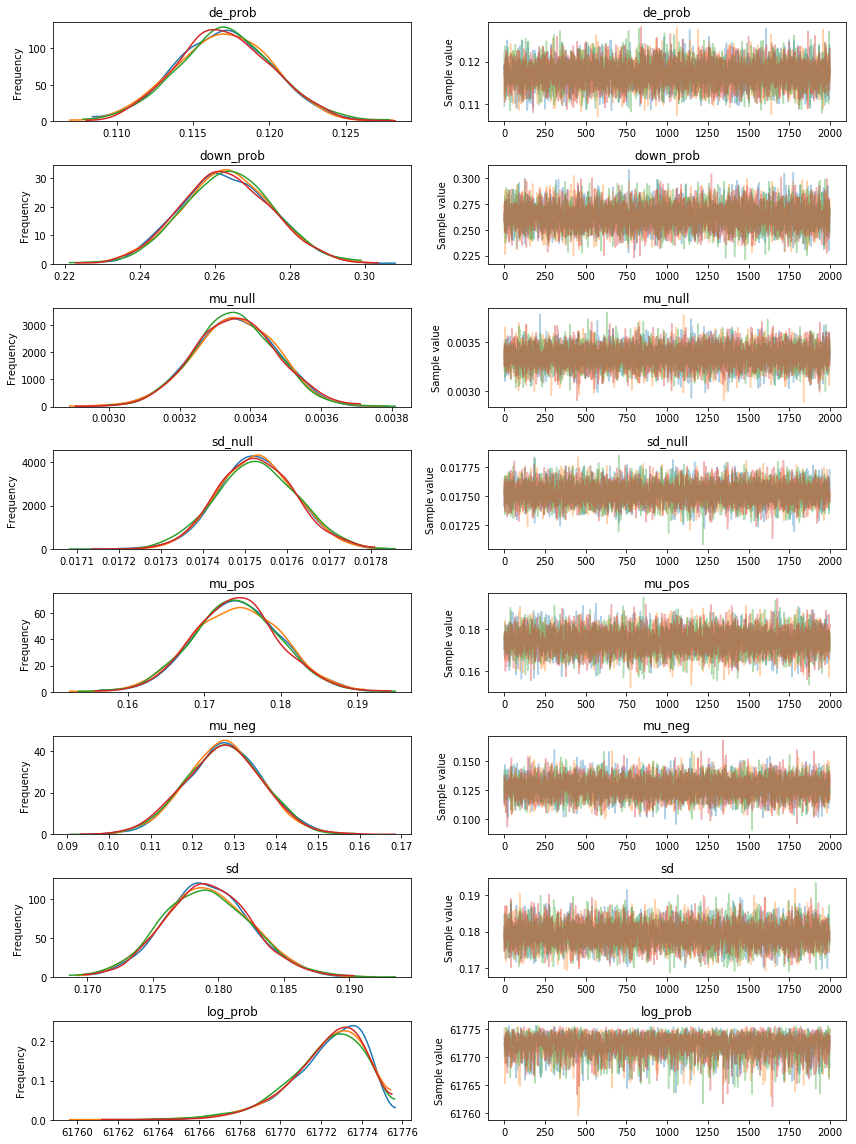

In [21]:
hgsc_res = run_model(logfcs_diff, logfcs_same, iter_count=2000, tune_iters = 2000)

pm.plots.traceplot(hgsc_res['trace'])

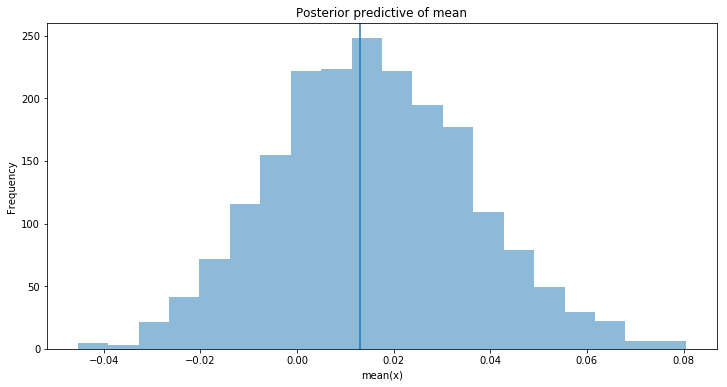

In [22]:
plot_posterior_predictive(hgsc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.mean(x, axis = 1), 
                          fun2 = lambda x: np.mean(x), 
                          xlab = "mean(x)",
                          title = "Posterior predictive of mean")

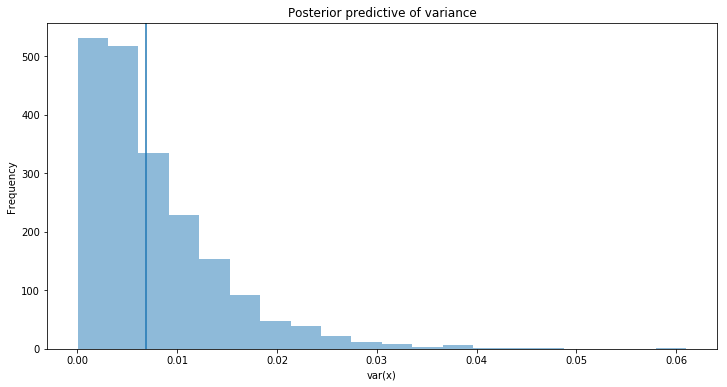

In [23]:
plot_posterior_predictive(hgsc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.var(x, axis = 1), 
                          fun2 = lambda x: np.var(x), 
                          xlab = "var(x)",
                          title = "Posterior predictive of variance")

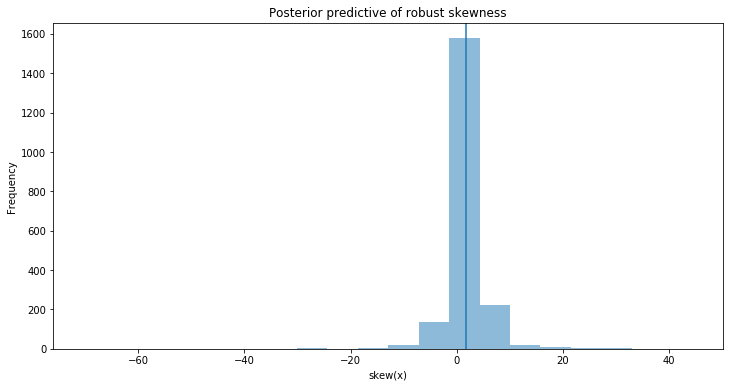

In [24]:
plot_posterior_predictive(hgsc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: statsmodels.stats.stattools.robust_skewness(x, axis = 1)[3], 
                          fun2 = lambda x: statsmodels.stats.stattools.robust_skewness(x)[3], 
                          xlab = "skew(x)",
                          title = "Posterior predictive of robust skewness")

Note that the $\mu_{pos}$ and $\mu_{neg}$ values are higher in this comparison than in the PBMC dataset. This could be due to a few reasons:

* Naive CD4+ and CD8+ T cells differ less than CD4+ and CD8+ T cells
* The 90\% probability threshold set for CellAssign predictions in the HGSC dataset filters out cells that may be assigned with less certainty to CD4+ or CD8+

## Cancer cells vs. fibroblasts

Cancer cells and fibroblasts should be fairly phenotypically distinct -- we can use this comparison as an example of the other end of the spectrum for these parameters.

In [123]:
class1 = "Monocyte/Macrophage"
class2 = "CD4 T cells"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

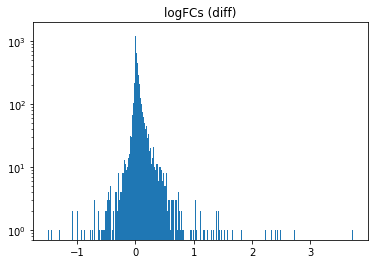

In [124]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

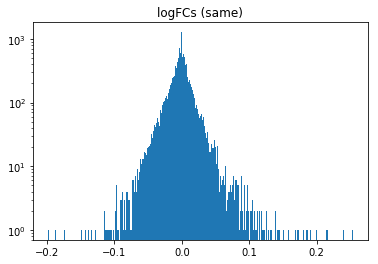

In [125]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 2000/2000 [00:53<00:00, 37.50it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9739e4a4e0>,
      dtype=object)

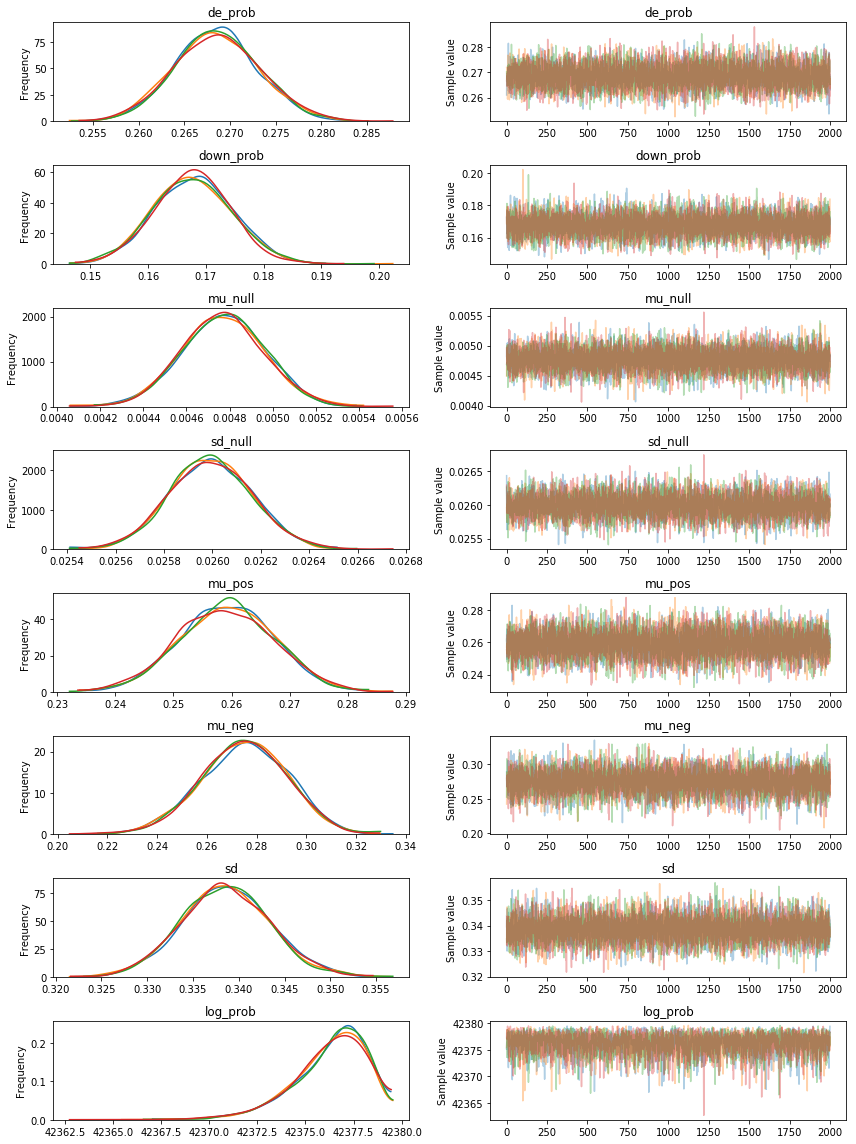

In [126]:
hgsc_res2 = run_model(logfcs_diff, logfcs_same, iter_count=2000, tune_iters = 2000)

pm.plots.traceplot(hgsc_res2['trace'])

As is clear, `de_prob`, $\mu_{pos}$, and $\mu_{neg}$ are higher due to the greater difference between fibroblasts and cancer cells. 

## Scratch

In [ ]:
def bf_comparison(observations, nulls, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        
        # Prior model probability
        pi = [0.01, 0.99]
        
        # Indicator variable for true model selected
        true_model = pm.Bernoulli('true_model', pi[1])
        
        ## MODEL 1
        
        # Probability of being a DE gene
        de_prob = pm.Uniform('de_prob', lower = 0., upper = 1.)

        # Probability of being downregulated
        down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for non-DE genes (learned from bootstrap resampling)
        mu_null = pm.Gamma('mu_null', alpha = 1., beta = 1.)
        sd_null = pm.Gamma('sd_null', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for DE genes
        mu_pos = pm.Lognormal('mu_pos', mu = 0., sd = 1.)
        mu_neg = pm.Lognormal('mu_neg', mu = 0., sd = 1.)

        sd = pm.Gamma('sd', alpha = 1., beta = 1.)

        # Sample from Gaussian for null
        pm.Normal('null',
                 mu = mu_null,
                 sd = sd_null,
                 observed = nulls)

        null_component = pm.Normal.dist(mu = mu_null,
                                      sd = sd_null)
        

        pos_component = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos, sd=sd)
        neg_component = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg, sd=sd)
        pos_component_abs = pm.Bound(pm.Normal, lower=0.).dist(mu=-1*mu_pos, sd=sd)
        neg_component_abs = pm.Bound(pm.Normal, upper=0.).dist(mu=mu_neg, sd=sd)
        
        cdf_pos = cdf(mu = mu_pos, sd = sd, value = 0.)
        cdf_neg = cdf(mu = -1*mu_neg, sd = sd, value = 0.)

        model1 = pm.Mixture.dist(
                  w = tt.as_tensor([(1.-de_prob), de_prob * (1.-down_prob) * (1.-cdf_pos), de_prob * down_prob * cdf_neg,
                                   de_prob * (1.-down_prob) * cdf_pos, de_prob * down_prob * (1.-cdf_neg)]),
                  comp_dists = [null_component, pos_component, neg_component, pos_component_abs,
                               neg_component_abs])
    
        ## MODEL 2
        
        # Probability of being a DE gene
        de_prob2 = pm.Uniform('de_prob2', lower = 0., upper = 1.)

        # Probability of being downregulated
        down_prob2 = pm.Beta('down_prob2', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for non-DE genes (learned from bootstrap resampling)
        mu_null2 = pm.Gamma('mu_null2', alpha = 1., beta = 1.)
        sd_null2 = pm.Gamma('sd_null2', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for DE genes
        mu_pos2 = pm.Lognormal('mu_pos2', mu = 0., sd = 1.)
        mu_neg2 = pm.Lognormal('mu_neg2', mu = 0., sd = 1.)

        sd2 = pm.Gamma('sd2', alpha = 1., beta = 1.)

        # Sample from Gaussian for null
        pm.Normal('null2',
                 mu = mu_null2,
                 sd = sd_null2,
                 observed = nulls)

        null_component2 = pm.Normal.dist(mu = mu_null2,
                                      sd = sd_null2)
        
        pos_component2 = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos2, sd=sd2)
        neg_component2 = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg2, sd=sd2)
        
        model2 = pm.Mixture.dist(
            w = tt.as_tensor([(1.-de_prob2), de_prob2 * (1.-down_prob2), de_prob2 * down_prob2]),
          comp_dists = [null_component2, pos_component2, neg_component2])
        
        ## MODEL COMPARISON
        
        Ylike = pm.DensityDist('Ylike',
            lambda value: pm.math.switch(true_model, 
                model1.logp(value), 
                model2.logp(value)
            ),
            observed=observations)
        
        step1 = pm.step_methods.Metropolis(vars=[true_model])
        step2 = pm.step_methods.NUTS(vars = [sd2, mu_neg2, mu_pos2, sd_null2, mu_null2, down_prob2, de_prob2, sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob])

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4, step = [step1, step2])
        #ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return(trace)